In [1]:
%load_ext autoreload
%autoreload 2

import galsim
import numpy as np
import ngmix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

In [2]:
SCALE = 0.25

In [3]:
import piff

PSF_MODEL = piff.PSF.read("piffs/D00240560_r_c58_r2362p01_piff.fits")

def get_piff_psf(col, row):
    image = galsim.ImageD(ncol=17, nrow=17, wcs=galsim.PixelScale(SCALE))
    _psf_im = PSF_MODEL.draw(x=int(col+0.5), y=int(row+0.5), image=image)
    _psf = galsim.InterpolatedImage(_psf_im, wcs=galsim.PixelScale(SCALE))
    print(_psf.calculateFWHM())
    return _psf_im.array

In [4]:
psf1 = get_piff_psf(200, 400)
psf2 = get_piff_psf(900, 10)

0.9056686334784425
0.9310791147319981


In [5]:
import ngmix

In [6]:
def _fit_ngmix(im):
    cen = (im.shape[0]-1) / 2
    obs = ngmix.Observation(
        image=im,
        jacobian=ngmix.UnitJacobian(row=cen, col=cen))
    fitter = ngmix.fitting.LMSimple(obs, "gauss")
    guess = np.zeros(6) + 1e-3
    guess[4:] += 1
    fitter.go(guess)
    res = fitter.get_result()
    return res['pars']

In [7]:
pars1 = _fit_ngmix(psf1)
pars2 = _fit_ngmix(psf2)
gm1 = ngmix.GMixModel(pars1, "gauss")
gm2 = ngmix.GMixModel(pars2, "gauss")

In [8]:
sz1 = np.sqrt(pars1[4]) * (1.0 + 2.0 * np.sqrt(np.sum(pars1[2:4]**2)))
sz2 = np.sqrt(pars2[4]) * (1.0 + 2.0 * np.sqrt(np.sum(pars2[2:4]**2)))

In [9]:
sz1, sz2

(2.707566452918814, 2.7036017535770975)

In [10]:
dpars = [1.0, 0.0, 0.0] + list(gm1.get_full_pars()[-3:] - gm2.get_full_pars()[-3:])
dpars[-3] = dpars[-3] + 0.02
dpars[-1] = dpars[-1] + 0.02

In [11]:
gmd = ngmix.GMix(pars=dpars)

In [14]:
imd = gmd.make_image((11, 11), jacobian=ngmix.DiagonalJacobian(scale=0.25, row=5, col=5))
imd /= imd.sum()

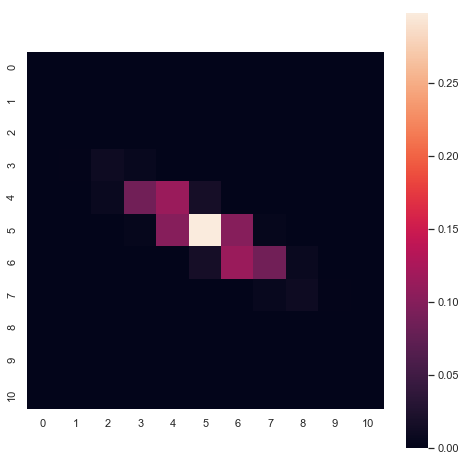

In [15]:
plt.figure(figsize=(8, 8))
sns.heatmap(imd, square=True)

In [16]:
from psf_homogenizer import upsample_image

upsf1 = upsample_image(psf1, 4, ensure_odd=True)
upsf2 = upsample_image(psf2, 4, ensure_odd=True)

In [18]:
import scipy.signal

hupsf2 = scipy.signal.convolve2d(upsf2, imd / np.sum(imd), mode='same')

In [19]:
from psf_homogenizer import downsample_image

dhupsf2 = downsample_image(hupsf2, 4, [17, 17])

In [20]:
pars = _fit_ngmix(dhupsf2)

In [25]:
["%0.5f" % p for p in pars]

['0.07086', '0.09056', '-0.03069', '0.01333', '6.52392', '0.88016']

In [26]:
["%0.5f" % p for p in pars1]

['0.01651', '0.09431', '-0.03156', '0.01212', '6.43176', '0.87516']

In [27]:
["%0.5f" % p for p in pars2]

['0.07064', '0.09049', '-0.03702', '0.00392', '6.33161', '0.87631']

In [28]:
from scipy.ndimage.filters import gaussian_filter

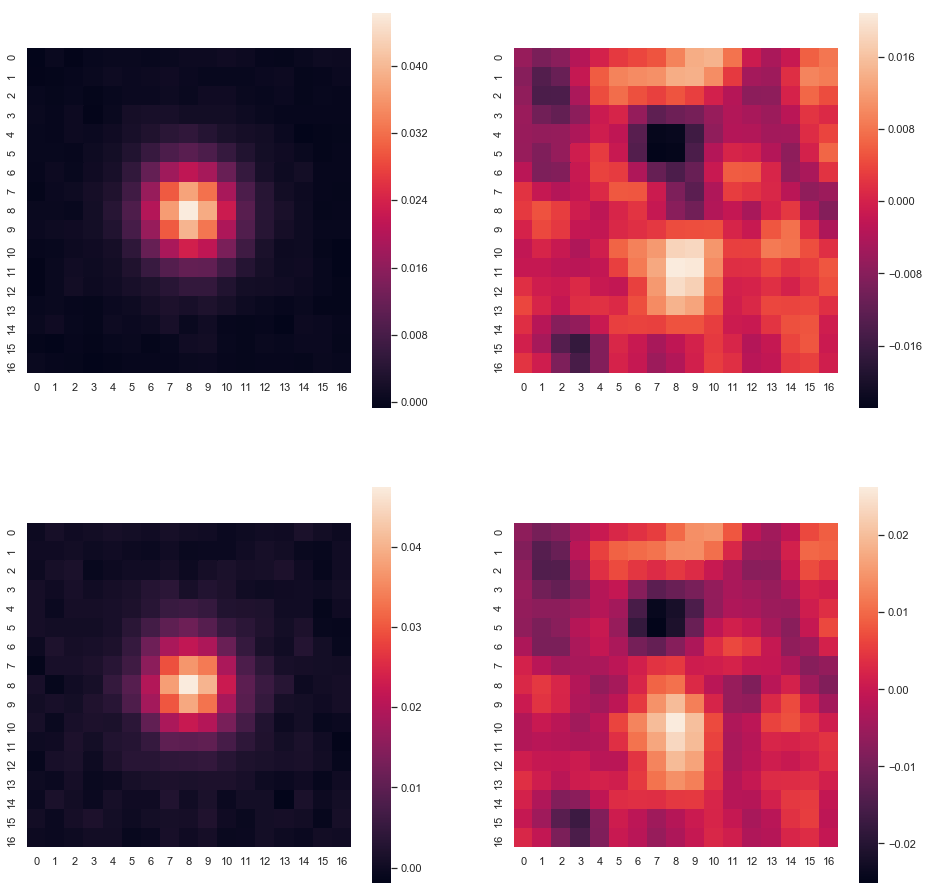

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax = axs[0, 0]
sns.heatmap(dhupsf2, square=True, ax=ax)

ax = axs[0, 1]
sns.heatmap(
    (gaussian_filter(dhupsf2, 1, mode='constant') - 
     gaussian_filter(psf1, 1, mode='constant'))/gaussian_filter(psf1, 1, mode='constant').max(), 
    square=True, ax=ax)

ax = axs[1, 0]
sns.heatmap(psf1, square=True, ax=ax)

ax = axs[1, 1]
sns.heatmap(
    (gaussian_filter(psf2, 1, mode='constant') - 
     gaussian_filter(psf1, 1, mode='constant'))/gaussian_filter(psf1, 1, mode='constant').max(), 
    square=True, ax=ax)

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(psf2)
plt.gca().grid(False)

In [ ]:
import scipy.fftpack

In [ ]:
ks = 9

ftgt = scipy.fftpack.fft2(np.pad(psf1, psf1.shape[0] * 2, 'constant', constant_values=0.0))
fpsf = scipy.fftpack.fft2(np.pad(psf2, psf2.shape[0] * 2, 'constant', constant_values=0.0))

krn = scipy.fftpack.fftshift(scipy.fftpack.ifft2(ftgt/fpsf).real)

sz = (krn.shape[0] - ks) // 2
krn = krn[sz:-sz, sz:-sz]
krn = krn / np.sum(krn)

In [ ]:
plt.figure()
plt.imshow(krn)
plt.gca().grid(False)

In [ ]:
import scipy.signal

In [ ]:
hpsf2 = scipy.signal.convolve2d(psf2, krn, mode='same')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax = axs[0]
sns.heatmap(hpsf2, square=True, ax=ax)

ax = axs[1]
sns.heatmap(psf2, square=True, ax=ax)
# sns.heatmap((hpsf2-psf1)/psf1.max(), square=True, ax=ax)

## A Simple Set of Gaussian Blobs

In [ ]:
SCALE = 0.25

In [ ]:
import piff

PSF_MODEL = piff.PSF.read("piffs/D00240560_r_c58_r2362p01_piff.fits")

def get_piff_psf(col, row):
    image = galsim.ImageD(ncol=17, nrow=17, wcs=galsim.PixelScale(SCALE))
    _psf_im = PSF_MODEL.draw(x=int(col+1.5), y=int(row+1.5), image=image)
    _psf = galsim.InterpolatedImage(_psf_im, wcs=galsim.PixelScale(SCALE))
    return _psf

In [ ]:
psf1 = get_piff_psf(200, 400)
psf2 = get_piff_psf(800, 10)

print(psf1.calculateFWHM(), psf2.calculateFWHM())

In [ ]:
obj = [galsim.Gaussian(fwhm=4).shift(-6, 0), galsim.Gaussian(fwhm=4).shift(6, 0)]

pobj = [
    galsim.Convolve(obj[0], psf1),
    galsim.Convolve(obj[1], psf2)]

hpobj = [
    galsim.Convolve(obj[0], psf2),
    galsim.Convolve(obj[1], psf2)]

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax = axs[0]
im = galsim.Sum(obj).drawImage(scale=SCALE, nx=120, ny=120, method='no_pixel')
ax.imshow(im.array)
ax.grid(False)

ax = axs[1]
im = galsim.Sum(pobj).drawImage(scale=SCALE, nx=120, ny=120, method='no_pixel')
ax.imshow(im.array)
ax.grid(False)

In [ ]:
def psf_model(row, col):
    if col >= 120/2:
        return psf2.drawImage(scale=SCALE, nx=17, ny=17, method='no_pixel').array
    else:
        return psf1.drawImage(scale=SCALE, nx=17, ny=17, method='no_pixel').array

In [ ]:
from psf_homogenizer import PSFHomogenizer

hpsf = PSFHomogenizer(
    psf_model, 120, 10, 
    kernel_size=9, 
    dilation_fudge=1.05)
hpsf.solve_for_kernel()

In [ ]:
%%time

im_orig = galsim.Sum(pobj).drawImage(scale=SCALE, nx=120, ny=120, method='no_pixel').array

imh = hpsf.apply_kernel(im_orig)

In [ ]:
def _subtract_mirrored(im, im_true):
    imn = np.zeros_like(im)
    mid = imn.shape[1] // 2
    imn[:, :mid] = im[:, :mid] - im_true[:, mid:][:, ::-1]
    imn[:, mid:] = im[:, mid:] - im_true[:, mid:]
    return imn

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax = axs[0, 1]
imp = _subtract_mirrored(im_orig, im_orig)
vmin = np.min(imp)
vmax = np.max(imp)
imp = (imp - vmin) / (vmax - vmin)
sns.heatmap(imp, ax=ax, square=True)
ax.grid(False)
ax.set_title('orig variation')

ax = axs[0, 0]
imp = _subtract_mirrored(imh, imh)
imp = (imp - np.min(imp))/(vmax - vmin)
sns.heatmap(imp, ax=ax, square=True)
ax.set_title('homogenized image variation')

ax = axs[1, 0]
sns.heatmap(imh - im_orig, ax=ax, square=True)
ax.set_title('homogenized - orig')

ax = axs[1, 1]
sns.heatmap(im_orig, ax=ax, square=True)
ax.set_title('orig')

In [ ]:
plt.figure()
plt.imshow(hpsf.get_kernel(80, 80))
plt.gca().grid(False)

In [ ]:
plt.figure()
plt.imshow(hpsf.get_kernel(0, 0))
plt.gca().grid(False)